# 1. Imports

In [2]:
import os
import re
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import optuna
from torch.utils.tensorboard import SummaryWriter

2025-03-22 16:48:13.533243: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 16:48:13.585415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 16:48:14.430705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# 2. Data Preprocessing

In [5]:
df = pd.read_csv('best_all_it_jobs.csv')
columns_to_keep = ['review_text', 'sentiment']
df = df[columns_to_keep].dropna(subset=['review_text'])

In [6]:
df.head(5)

,review_text,sentiment
0,"Be ready to work hard, but really learn and gr...",Positive
1,Freelancing is for me i want to earn money fin...,Neutral
2,Not all change is for the better. Flexible for...,Positive
3,Good people Great people and schedule. Get to...,Positive
4,"DON'T WORK HERE Low pay, poor treatment, hosti...",Negative


In [7]:
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df['label'] = df['sentiment'].map(label_map)

In [8]:
df_sampled = (df.groupby("sentiment")
              .sample(n=20000, random_state=SEED, replace=True)
              .reset_index(drop=True))

In [9]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [10]:
def get_wordnet_pos(tag):
    return {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }.get(tag[0], wordnet.NOUN)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', text.lower())
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) 
              for w, tag in pos_tag(nltk.word_tokenize(text)) 
              if w not in stop_words]
    return ' '.join(tokens)

In [11]:
df_sampled['cleaned_review'] = df_sampled['review_text'].apply(preprocess_text)
df_sampled = df_sampled[df_sampled['cleaned_review'].str.strip().astype(bool)]

# 3. Data Splitting


In [12]:
train_df, temp_df = train_test_split(
    df_sampled, test_size=0.3, stratify=df_sampled['sentiment'], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=SEED
)

# 4. Tokenization

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_review'])

In [14]:
def prepare_sequences(df, max_length=250):
    sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
    lengths = [min(len(seq), max_length) for seq in sequences]
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded, lengths

In [15]:
X_train, train_lengths = prepare_sequences(train_df)
X_val, val_lengths = prepare_sequences(val_df)
X_test, test_lengths = prepare_sequences(test_df)

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['sentiment'])
y_val = le.transform(val_df['sentiment'])
y_test = le.transform(test_df['sentiment'])

# 5. Word Embedding

In [17]:
def load_glove_embeddings(path, tokenizer, embed_dim):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings_index[word] = vector

    vocab_size = tokenizer.num_words + 1
    embedding_matrix = np.zeros((vocab_size, embed_dim))
    
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:
            continue
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
            
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_matrix = load_glove_embeddings('glove.6B.100d.txt', tokenizer, 100)

# 6. DataLoader Function

In [18]:
def create_dataloader(X, lengths, y, batch_size=128, shuffle=False):
    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.long),
        torch.tensor(lengths, dtype=torch.long),
        torch.tensor(y, dtype=torch.long)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

# 7. Define Model

In [19]:
class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 num_layers, dropout, pretrained_embeddings=None):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False) \
            if pretrained_embeddings is not None \
            else nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (hidden, _) = self.lstm(packed)
        
        num_layers = self.lstm.num_layers
        hidden_forward = hidden[:num_layers, :, :]
        hidden_backward = hidden[num_layers:, :, :]
        
        last_hidden_forward = hidden_forward[-1, :, :]
        last_hidden_backward = hidden_backward[-1, :, :]

        combined = torch.cat((last_hidden_forward, last_hidden_backward), dim=1)
        
        return self.fc(self.dropout(combined))

# 8. Training Function

In [20]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for X, lengths, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X, lengths)
        loss = criterion(outputs, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == y).sum().item()
    return total_loss/len(loader), correct/len(loader.dataset)

# 9. Evaluation Function

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for X, lengths, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X, lengths)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y).sum().item()
    return total_loss/len(loader), correct/len(loader.dataset)

In [ ]:
def evaluate_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, lengths, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X, lengths)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    return cm, acc, f1, precision, recall

# 10. Hyperparameter Tuning with Optuna

In [21]:
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [128, 256, 512]),
        'num_layers': num_layers,
        'dropout': trial.suggest_float('dropout', 0.1, 0.5) if num_layers > 1 else 0.0,
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'num_epochs': trial.suggest_int('num_epochs', 5, 10),
        'grad_clip': trial.suggest_float('grad_clip', 0.5, 1.5)
    }

    train_loader_trial = create_dataloader(X_train, train_lengths, y_train, batch_size=params['batch_size'], shuffle=True)
    val_loader_trial = create_dataloader(X_val, val_lengths, y_val, batch_size=params['batch_size'])
    
    model = SentimentBiLSTM(
        vocab_size=10001,
        embed_dim=100,
        output_dim=len(le.classes_),
        pretrained_embeddings=embedding_matrix,
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter()
    
    best_val_acc = 0
    patience = 2
    no_improvement = 0
    
    for epoch in range(params['num_epochs']):
        train_loss, train_acc = train(model, train_loader_trial, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader_trial, criterion, device)
        scheduler.step()
        
        trial.report(val_acc, epoch)
        if trial.should_prune():
            writer.close()
            raise optuna.TrialPruned()
            
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                break
    writer.close()
    return best_val_acc

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Optuna Params:", study.best_params)

[I 2025-03-22 16:50:28,927] A new study created in memory with name: no-name-de4c6dc2-fbd9-474f-8213-1a081e1e629f
[I 2025-03-22 16:51:32,240] Trial 0 finished with value: 0.7331111111111112 and parameters: {'num_layers': 1, 'hidden_dim': 512, 'lr': 0.0008683711408101079, 'batch_size': 256, 'weight_decay': 0.0007558105657669164, 'num_epochs': 6, 'grad_clip': 1.4241560643788684}. Best is trial 0 with value: 0.7331111111111112.
[I 2025-03-22 16:52:03,633] Trial 1 finished with value: 0.7146666666666667 and parameters: {'num_layers': 1, 'hidden_dim': 128, 'lr': 0.0003257791549607255, 'batch_size': 128, 'weight_decay': 0.0003388775198956191, 'num_epochs': 5, 'grad_clip': 0.7234346791912275}. Best is trial 0 with value: 0.7331111111111112.
[I 2025-03-22 16:53:28,928] Trial 2 finished with value: 0.702 and parameters: {'num_layers': 2, 'hidden_dim': 128, 'dropout': 0.344753651375505, 'lr': 0.00015853252859460956, 'batch_size': 128, 'weight_decay': 1.3900843349993574e-06, 'num_epochs': 10, 'gr

Best Optuna Params: {'num_layers': 3, 'hidden_dim': 256, 'dropout': 0.2247206900151345, 'lr': 0.009091036175481425, 'batch_size': 128, 'weight_decay': 0.0001373613031112612, 'num_epochs': 8, 'grad_clip': 1.4901947031145073}


In [23]:
best_params = study.best_params

# 11. Final Training with Best Parameters

In [24]:
final_model = SentimentBiLSTM(
    vocab_size=10001,
    embed_dim=100,
    output_dim=len(le.classes_),
    pretrained_embeddings=embedding_matrix,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=0
).to(device)

In [25]:
train_loader = create_dataloader(X_train, train_lengths, y_train, batch_size=best_params['batch_size'], shuffle=True)
val_loader = create_dataloader(X_val, val_lengths, y_val, batch_size=best_params['batch_size'])
test_loader = create_dataloader(X_test, test_lengths, y_test, batch_size=best_params['batch_size'])

In [26]:
optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.CrossEntropyLoss()

In [27]:
num_epochs = best_params['num_epochs']
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(final_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(final_model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')

Epoch 1: Train Loss: 0.7834 | Val Acc: 0.7114
Epoch 2: Train Loss: 0.6035 | Val Acc: 0.7301
Epoch 3: Train Loss: 0.5080 | Val Acc: 0.7388
Epoch 4: Train Loss: 0.4273 | Val Acc: 0.7312
Epoch 5: Train Loss: 0.3680 | Val Acc: 0.7387
Epoch 6: Train Loss: 0.3306 | Val Acc: 0.7397
Epoch 7: Train Loss: 0.2990 | Val Acc: 0.7378
Epoch 8: Train Loss: 0.2700 | Val Acc: 0.7399


# 12. Training Graphs

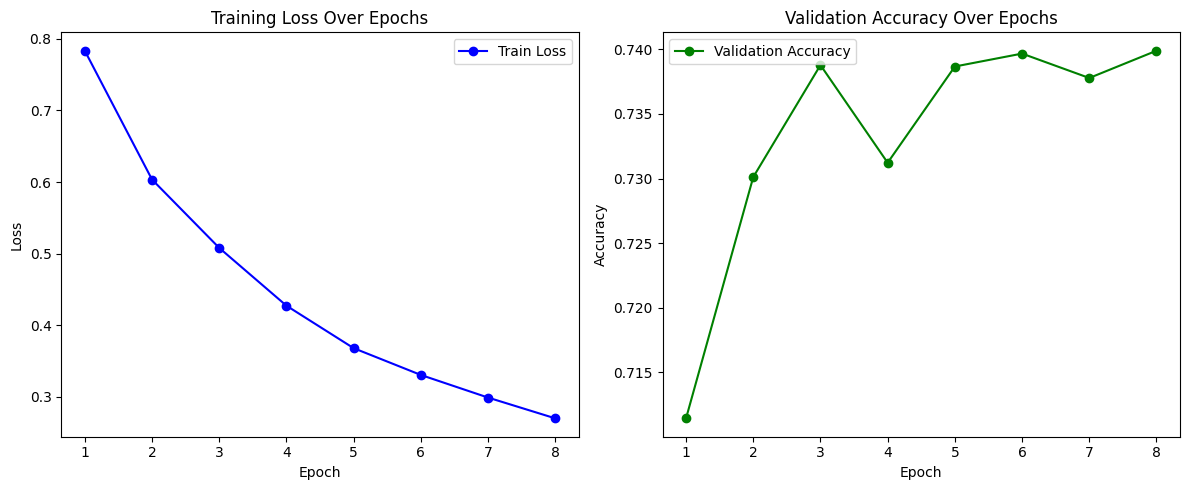

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 13. Final Evaluation


Test Loss: 0.8290 | Test Accuracy: 0.7460 | F1: 0.7463 | Precision: 0.7495 | Recall: 0.7460


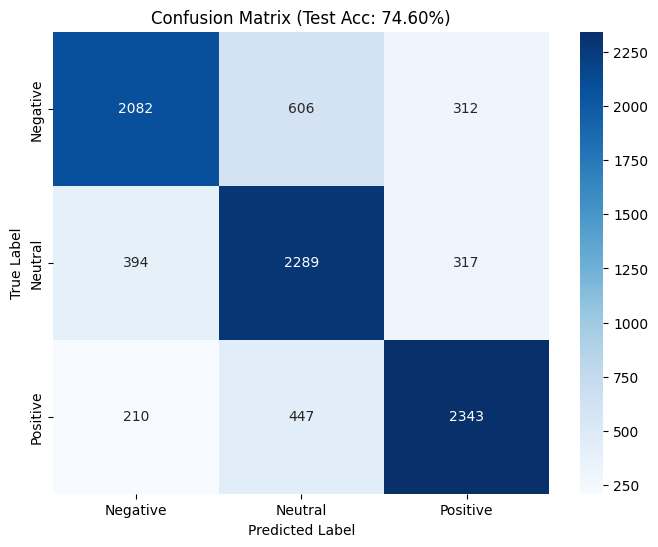

In [29]:
test_loss, test_acc = evaluate(final_model, test_loader, criterion, device)
cm, acc, f1, precision, recall = evaluate_metrics(final_model, test_loader, device)
print(f'\nTest Loss: {test_loss:.4f} | Test Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title(f'Confusion Matrix (Test Acc: {acc:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()